In [2]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.ensemble import RandomForestClassifier

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:
import optuna
from sklearn.model_selection import KFold, cross_val_score
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    hamming_loss,
    f1_score,
    jaccard_score,
    make_scorer,
)
import matplotlib.pyplot as plt


/Users/xiaomuou620/opt/miniconda3/envs/Project1/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Read fingerprint file and experimental file

read fingerprint file and experiment data file

In [4]:
receptors = pd.read_csv(
    "/Users/xiaomuou620/Desktop/PRIVATE_DATA/hallucinome.csv"  # have aligned the name Bromo-dragonFLY to Bromo-DragonFLY
)
fingerprints = pd.read_csv('../../data/ExperimentData/MACCS_fingerprints.csv')

print(receptors.head())
print(receptors.shape)
print(fingerprints.shape)

  receptor gprotein        drug    Emax  Emax_SE    TCoeff  TCoeff_SE  \
0    5HT1A      Gi1   25C-NBOMe  999.00   999.00       NaN        NaN   
1    5HT1A      Gi1    25I-NBMD   18.62     2.06  8.878197   0.201061   
2    5HT1A      Gi1   25I-NBOMe   24.53     3.28  7.947086   0.195392   
3    5HT1A      Gi1  25T7-NBOMe   22.00     3.87  7.457872   0.217788   
4    5HT1A      Gi1  4-AcO-MALT   38.93     5.16  7.417719   0.148907   

    logEmEC  logEmEc_Lower  logEmEc_Upper   pEC50  pEC50_SE  N  
0       NaN            NaN            NaN  999.00    999.00  3  
1  8.879980       8.529060       9.225551    7.61      0.30  3  
2  7.949698       7.607359       8.284201    6.56      0.28  3  
3  7.462423       7.078398       7.832796    6.12      0.30  3  
4  7.420284       7.158531       7.674340    5.83      0.20  3  
(4059, 13)
(43, 168)


### Experimental data processing

In [5]:
# replace 999 in Emax with 0
receptors["Emax"] = receptors["Emax"].replace(999, 0)
# print(receptors.head())

# collect receptors for each drug
receptor_emax_mapping = (
    receptors.groupby(["drug", "receptor"])["Emax"].max().reset_index()
)
# print(receptor_emax_mapping.head())

# pivot the table to have drugs as rows and receptors as columns
receptor_emax_mapping_pivot = receptor_emax_mapping.pivot(
    index="drug", columns="receptor", values="Emax"
).reset_index()
print(receptor_emax_mapping_pivot.head())

receptor_emax_mapping_pivot.fillna(0, inplace=True)
print(receptor_emax_mapping_pivot.shape)

receptor        drug      5HT1A       5HT1B   5HT1D   5HT1E       5HT1F  \
0          25C-NBOMe  13.047601    0.000000   61.56    0.00    0.000000   
1           25I-NBMD  27.200000   84.239297   91.94  105.26  102.099230   
2          25I-NBOMe  45.370000    0.000000   53.65   33.92   64.596780   
3         25T7-NBOMe  31.991315    0.000000   31.81    0.00   69.116817   
4         4-AcO-MALT  50.677696  126.170618  101.04  115.53  102.552716   

receptor   5HT2A  5HT2B   5HT2C  5HT5A  ...  Alpha2B  Alpha2C  Beta1AR  \
0         126.52  67.19   98.15   0.00  ...      0.0      0.0      0.0   
1         102.02  45.49   79.79   0.00  ...      0.0      0.0      0.0   
2         108.36  72.04  104.43  27.97  ...      0.0      0.0      0.0   
3          99.15  53.73   94.85  36.81  ...      0.0      0.0      0.0   
4         102.61  68.11  110.35  43.88  ...      0.0      0.0      0.0   

receptor  Beta2AR  Beta3AR  DRD1   DRD2   DRD3  DRD4   DRD5  
0             0.0      0.0   0.0  50.60   

binarize the experiment data file -> create multilabel for receptors

In [6]:
# set the threshold for binarization
threshold = 0

# transform the data
multi_label_data = receptor_emax_mapping_pivot.copy()
receptors = multi_label_data.columns[1:]  

# binarize the receptors
multi_label_data[receptors] = (multi_label_data[receptors] > threshold).astype(int)

print(multi_label_data.shape)
print(fingerprints.shape)


(44, 26)
(43, 168)


Here, labels have 44 lines and fingerprints have 43 lines, including the header.

Since I cannot find the category and SMILES of METALLED, when merging the data, METALLED data will be disgarded.


In [7]:
# merge the data based on the drug names (make sure the names are lower case when comparing)
drug_receptor_label = pd.merge(
    fingerprints.assign(Name_lower=fingerprints["Name"].str.strip().str.lower()),
    multi_label_data.assign(
        drug_lower=multi_label_data["drug"].str.strip().str.lower()
    ),
    left_on="Name_lower",
    right_on="drug_lower",
    how="left",
)

# change back to the original drug name
drug_receptor_label.drop(columns=["Name_lower", "drug_lower"], inplace=True)

print(fingerprints.shape)
print(drug_receptor_label.shape)
drug_receptor_label.to_csv("drug_receptor_label.csv", index=False)

(43, 168)
(43, 194)


In [8]:
drug_label = drug_receptor_label.drop(columns=['Name', 'drug'])
print(drug_label.head())
# drug_label.to_csv('/Users/xiaomuou620/Desktop/PRIVATE_DATA/selected_file_multilabel.csv', index=False)

# drug_dict = drug_label.to_dict()
# print(drug_dict)

   0  1  2  3  4  5  6  7  8  9  ...  Alpha2B  Alpha2C  Beta1AR  Beta2AR  \
0  0  0  0  0  0  0  0  0  0  0  ...        0        0        0        0   
1  0  0  0  0  0  0  0  0  0  0  ...        0        0        0        0   
2  0  0  0  0  0  0  0  0  0  0  ...        0        0        0        0   
3  0  0  0  0  0  0  0  0  0  0  ...        0        0        0        0   
4  0  0  0  0  0  0  0  0  0  0  ...        0        0        0        0   

   Beta3AR  DRD1  DRD2  DRD3  DRD4  DRD5  
0        0     0     1     1     0     0  
1        0     0     1     1     0     0  
2        0     0     1     1     1     0  
3        0     0     1     1     1     1  
4        0     0     0     0     1     0  

[5 rows x 192 columns]


### Merge feature and labels

merge features and labels -> to ensure the features and labels match based on drugs

# Training

Since MACCS only has 166 bits and the first bit 0 always unset and may be ignored. Only bits 1-166 will be set

In [9]:
X = drug_label.iloc[:, 1:167]
y = drug_label.iloc[:, 167:]

print(X.shape, y.shape)
print(X.head())
print(y.head())
# 


(43, 166) (43, 25)
   1  2  3  4  5  6  7  8  9  10  ...  157  158  159  160  161  162  163  164  \
0  0  0  0  0  0  0  0  0  0   0  ...    1    1    1    0    1    1    1    1   
1  0  0  0  0  0  0  0  0  0   0  ...    1    1    1    1    1    1    1    1   
2  0  0  0  0  0  0  0  0  0   0  ...    1    1    0    1    1    1    1    1   
3  0  0  0  0  0  0  0  0  0   0  ...    1    1    0    1    1    1    1    1   
4  0  0  0  0  0  0  0  0  0   0  ...    1    1    0    1    1    1    1    1   

   165  166  
0    1    0  
1    1    0  
2    1    0  
3    1    0  
4    1    0  

[5 rows x 166 columns]
   5HT1A  5HT1B  5HT1D  5HT1E  5HT1F  5HT2A  5HT2B  5HT2C  5HT5A  5HT6  ...  \
0      1      1      1      1      1      1      1      1      1     1  ...   
1      1      1      1      1      1      1      1      1      1     1  ...   
2      1      1      1      1      1      1      1      1      1     1  ...   
3      1      1      1      1      1      1      1      1      0     1

## Optuna + Nested CV

In [10]:

# Nested cross-validation setup
outer_ncv = KFold(n_splits=5, shuffle=True, random_state=42)
inner_ncv = KFold(n_splits=5, shuffle=True, random_state=43)


# Define the objective function for the Inner loop
def objective(trial, X_train_inner, y_train_inner):
    # Define hyperparameters to optimize
    n_estimators = trial.suggest_int("n_estimators", 10, 100)
    max_depth = trial.suggest_int("max_depth", 5, 20)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 5)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 4)
    bootstrap = trial.suggest_categorical("bootstrap", [True, False])

    # Create a random forest classifier
    rf_classifier = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        bootstrap=bootstrap,
        random_state=42,
    )

    # Cross-validation for hyperparameter tuning
    scoring = make_scorer(
        hamming_loss, greater_is_better=False
    )  # Minimize Hamming loss
    cv_scores = cross_val_score(
        rf_classifier, X_train_inner, y_train_inner, cv=inner_ncv, scoring=scoring
    )
    return -cv_scores.mean() # -cv mean because make_scorer is greater_is_better=False, which will give negative values of hamming loss


In [11]:
# Outer loop: Statistical evaluation
outer_scores = []
ncv_label_scores = {label: [] for label in y.columns}


for train_index, test_index in outer_ncv.split(X, y):
    # Split data into training and testing sets for the outer fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Inner loop: Hyperparameter search
    study = optuna.create_study(direction="minimize")
    study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=50)

    # Train the model using the best hyperparameters
    best_params = study.best_params
    best_rf_classifier = RandomForestClassifier(**best_params, random_state=42)
    best_rf_classifier.fit(X_train, y_train)

    # Get predicted probabilities
    # y_test_pred_proba = best_rf_classifier.predict_proba(X_test)

    # Convert predicted probabilities to predicted labels 
    y_test_pred = best_rf_classifier.predict(X_test) # could change to predict_proba using different threshold to predict labels

    # Evaluate the model on the outer fold's test set
    outer_scores.append(
        {
            "accuracy": accuracy_score(y_test, y_test_pred),
            "hamming_loss": hamming_loss(y_test, y_test_pred),
            "f1_micro": f1_score(y_test, y_test_pred, average="micro"),
            "jaccard_samples": jaccard_score(y_test, y_test_pred, average="samples"),
        }
    )
    

    # Calculate metrics for each label
    for label in y.columns:
        ncv_label_scores[label].append(
            {
                "accuracy": accuracy_score(
                    y_test[label], y_test_pred[:, y.columns.get_loc(label)]
                ),
                "hamming_loss": hamming_loss(
                    y_test[label], y_test_pred[:, y.columns.get_loc(label)]
                ),
                "f1_score": f1_score(
                    y_test[label], y_test_pred[:, y.columns.get_loc(label)]
                ),
                "jaccard_score": jaccard_score(
                    y_test[label], y_test_pred[:, y.columns.get_loc(label)]
                ),
            }
        )
        
    
# Calculate mean and standard deviation for overall metrics
ncv_metrics = {key: [score[key] for score in outer_scores] for key in outer_scores[0]}
for metric, values in ncv_metrics.items():
    print(
        f"{metric.capitalize()}: Mean = {np.mean(values):.2f}, Std = {np.std(values):.2f}"
    )
    

[I 2025-01-10 11:37:35,451] A new study created in memory with name: no-name-0e636898-5603-4ad5-893b-b519f39ccc8a
[I 2025-01-10 11:37:35,796] Trial 0 finished with value: 0.16647619047619047 and parameters: {'n_estimators': 16, 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 0 with value: 0.16647619047619047.
[I 2025-01-10 11:37:36,428] Trial 1 finished with value: 0.16876190476190475 and parameters: {'n_estimators': 83, 'max_depth': 11, 'min_samples_split': 5, 'min_samples_leaf': 3, 'bootstrap': False}. Best is trial 0 with value: 0.16647619047619047.
[I 2025-01-10 11:37:37,132] Trial 2 finished with value: 0.15828571428571428 and parameters: {'n_estimators': 82, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': True}. Best is trial 2 with value: 0.15828571428571428.
[I 2025-01-10 11:37:37,585] Trial 3 finished with value: 0.17466666666666666 and parameters: {'n_estimators': 58, 'max_depth': 15, 'min_samples_

Accuracy: Mean = 0.05, Std = 0.06
Hamming_loss: Mean = 0.14, Std = 0.03
F1_micro: Mean = 0.87, Std = 0.03
Jaccard_samples: Mean = 0.74, Std = 0.06


/Users/xiaomuou620/opt/miniconda3/envs/Project1/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/xiaomuou620/opt/miniconda3/envs/Project1/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/xiaomuou620/opt/miniconda3/envs/Project1/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predic

In [12]:
print("Best Hyperparameters:", study.best_params)

Best Hyperparameters: {'n_estimators': 37, 'max_depth': 17, 'min_samples_split': 4, 'min_samples_leaf': 2, 'bootstrap': False}


### Evaluation

"accuracy", "hamming_loss", "f1_score", "jaccard_score"

/Users/xiaomuou620/opt/miniconda3/envs/Project1/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/xiaomuou620/opt/miniconda3/envs/Project1/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/xiaomuou620/opt/miniconda3/envs/Project1/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predic

Accuracy: Mean = 0.05, Std = 0.06
Hamming_loss: Mean = 0.14, Std = 0.03
F1_micro: Mean = 0.87, Std = 0.03
Jaccard_samples: Mean = 0.74, Std = 0.06

Metrics for label: 5HT1A
Accuracy: Mean = 0.86, Std = 0.11
Hamming_loss: Mean = 0.14, Std = 0.11
F1_score: Mean = 0.92, Std = 0.07
Jaccard_score: Mean = 0.86, Std = 0.11

Metrics for label: 5HT1B
Accuracy: Mean = 0.86, Std = 0.11
Hamming_loss: Mean = 0.14, Std = 0.11
F1_score: Mean = 0.92, Std = 0.07
Jaccard_score: Mean = 0.86, Std = 0.11

Metrics for label: 5HT1D
Accuracy: Mean = 0.95, Std = 0.06
Hamming_loss: Mean = 0.05, Std = 0.06
F1_score: Mean = 0.97, Std = 0.03
Jaccard_score: Mean = 0.95, Std = 0.06

Metrics for label: 5HT1E
Accuracy: Mean = 0.86, Std = 0.13
Hamming_loss: Mean = 0.14, Std = 0.13
F1_score: Mean = 0.92, Std = 0.08
Jaccard_score: Mean = 0.86, Std = 0.13

Metrics for label: 5HT1F
Accuracy: Mean = 0.93, Std = 0.09
Hamming_loss: Mean = 0.07, Std = 0.09
F1_score: Mean = 0.96, Std = 0.05
Jaccard_score: Mean = 0.93, Std = 0.0

/Users/xiaomuou620/opt/miniconda3/envs/Project1/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/xiaomuou620/opt/miniconda3/envs/Project1/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/xiaomuou620/opt/miniconda3/envs/Project1/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predic

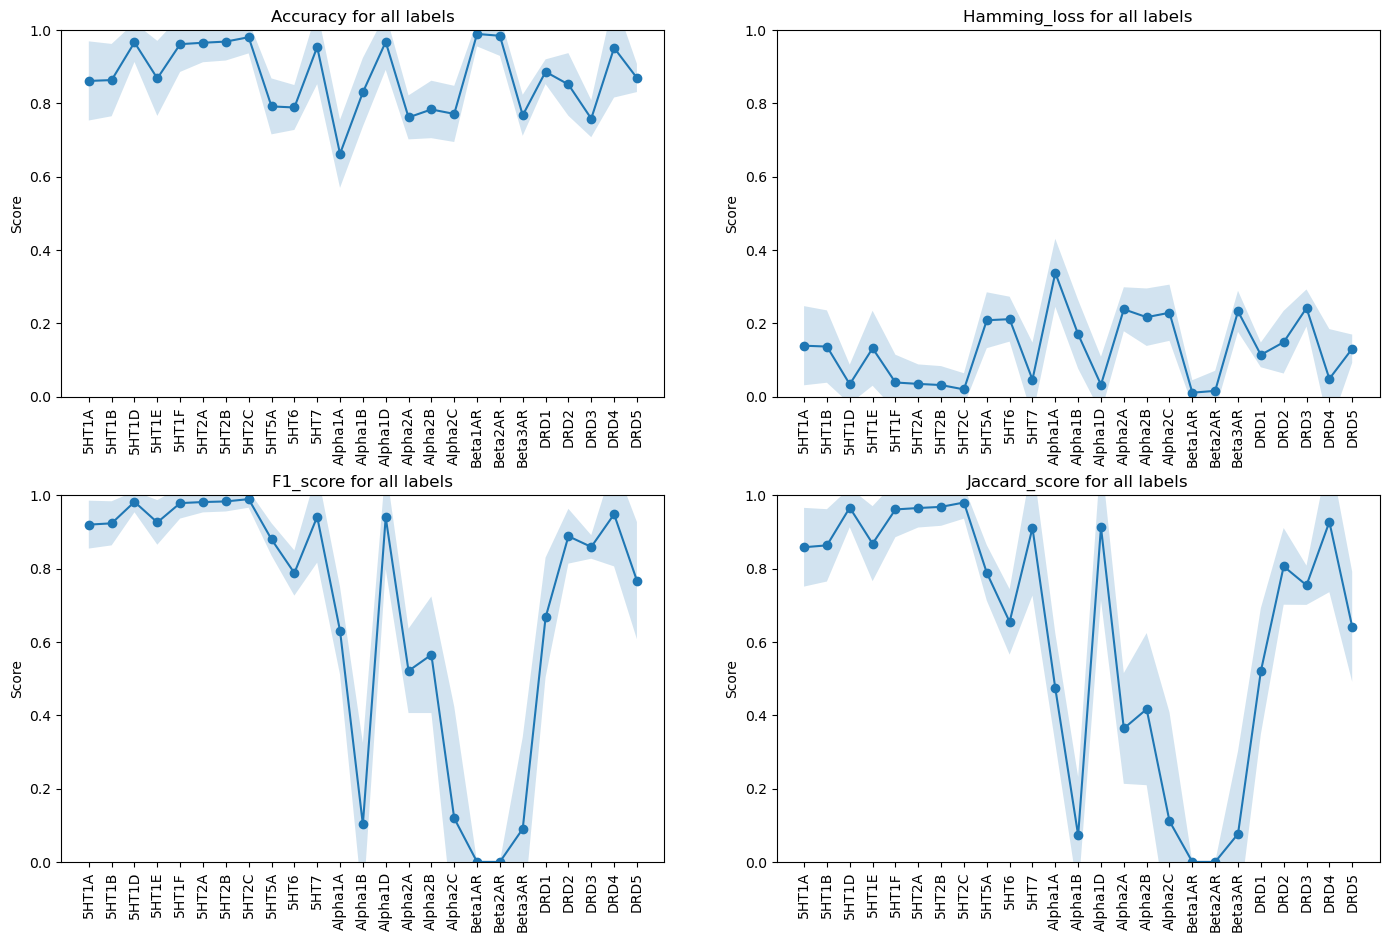

In [13]:
# Calculate mean and standard deviation for overall metrics
metrics = {key: [score[key] for score in outer_scores] for key in outer_scores[0]}
for metric, values in metrics.items():
    print(
        f"{metric.capitalize()}: Mean = {np.mean(values):.2f}, Std = {np.std(values):.2f}"
    )
    
# Calculate mean and standard deviation for each label's metrics
for label, scores in ncv_label_scores.items():
    print(f"\nMetrics for label: {label}")
    label_metrics = {key: [score[key] for score in scores] for key in scores[0]}
    for metric, values in label_metrics.items():
        print(
            f"{metric.capitalize()}: Mean = {np.mean(values):.2f}, Std = {np.std(values):.2f}"
        )
    

# Calculate mean and standard deviation for each label's metrics
ncv_label_metrics_summary = {}
for label, scores in ncv_label_scores.items():
    label_metrics = {key: [score[key] for score in scores] for key in scores[0]}
    ncv_label_metrics_summary[label] = {
        metric: (np.mean(values), np.std(values))
        for metric, values in label_metrics.items()
    }

    # Calculate metrics for each label
    for label in y.columns:
        ncv_label_scores[label].append(
            {
                "accuracy": accuracy_score(
                    y_test[label], y_test_pred[:, y.columns.get_loc(label)]
                ),
                "hamming_loss": hamming_loss(
                    y_test[label], y_test_pred[:, y.columns.get_loc(label)]
                ),
                "f1_score": f1_score(
                    y_test[label], y_test_pred[:, y.columns.get_loc(label)]
                ),
                "jaccard_score": jaccard_score(
                    y_test[label], y_test_pred[:, y.columns.get_loc(label)]
                ),
            }
        )

# Plotting the metrics for each label
metrics_to_plot = ["accuracy", "hamming_loss", "f1_score", "jaccard_score"]
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()
fig.tight_layout(pad=5.0)


for i, metric in enumerate(metrics_to_plot):
    ax = axes[i]
    ax.set_title(f"{metric.capitalize()} for all labels")
    means = [ncv_label_metrics_summary[label][metric][0] for label in y.columns]
    stds = [ncv_label_metrics_summary[label][metric][1] for label in y.columns]

    ax.plot(range(len(y.columns)), means, marker="o")
    ax.fill_between(
        range(len(y.columns)),
        np.array(means) - np.array(stds),
        np.array(means) + np.array(stds),
        alpha=0.2,
    )

    ax.set_ylabel("Score")
    ax.set_ylim(0, 1)
    ax.set_xticks(range(len(y.columns)))
    ax.set_xticklabels(y.columns, rotation=90)

plt.show()


## Optuna + CV

In [14]:
# cross-validation setup
cv = KFold(n_splits=5, shuffle=True, random_state=42)


# Define the objective function for without Inner loop
def objective(trial, X_train_inner, y_train_inner):
    # Define hyperparameters to optimize
    n_estimators = trial.suggest_int("n_estimators", 10, 100)
    max_depth = trial.suggest_int("max_depth", 5, 20)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 5)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 4)
    bootstrap = trial.suggest_categorical("bootstrap", [True, False])

    # Create a random forest classifier
    rf_classifier = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        bootstrap=bootstrap,
        random_state=42,
    )

    rf_classifier.fit(X_train, y_train)
    y_pred = rf_classifier.predict(X_train)
    
    return hamming_loss(y_train, y_pred)

In [15]:
cv_scores = []
cv_label_scores = {label: [] for label in y.columns}

for train_index, test_index in cv.split(X, y):
    # Split data into training and testing sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Hyperparameter search
    study = optuna.create_study(direction="minimize")
    study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=50)

    # Train the model using the best hyperparameters
    best_params = study.best_params
    best_rf_classifier = RandomForestClassifier(**best_params, random_state=42)
    best_rf_classifier.fit(X_train, y_train)

    # Predict on test set
    y_test_pred = best_rf_classifier.predict(X_test)

    # Evaluate the model
    cv_scores.append(
        {
            "accuracy": accuracy_score(y_test, y_test_pred),
            "hamming_loss": hamming_loss(y_test, y_test_pred),
            "f1_micro": f1_score(y_test, y_test_pred, average="micro"),
            "jaccard_samples": jaccard_score(y_test, y_test_pred, average="samples"),
        }
    )

    # Calculate metrics for each label
    for label in y.columns:
        cv_label_scores[label].append(
            {
                "accuracy": accuracy_score(
                    y_test[label], y_test_pred[:, y.columns.get_loc(label)]
                ),
                "hamming_loss": hamming_loss(
                    y_test[label], y_test_pred[:, y.columns.get_loc(label)]
                ),
                "f1_score": f1_score(
                    y_test[label], y_test_pred[:, y.columns.get_loc(label)]
                ),
                "jaccard_score": jaccard_score(
                    y_test[label], y_test_pred[:, y.columns.get_loc(label)]
                ),
            }
        )

# Calculate mean and standard deviation for overall metrics
cv_metrics = {key: [score[key] for score in cv_scores] for key in cv_scores[0]}
for metric, values in cv_metrics.items():
    print(
        f"{metric.capitalize()}: Mean = {np.mean(values):.2f}, Std = {np.std(values):.2f}"
    )


[I 2025-01-10 11:39:49,434] A new study created in memory with name: no-name-ee6c4648-3fa5-45c5-ace4-f0d71acf61d4
[I 2025-01-10 11:39:49,582] Trial 0 finished with value: 0.0 and parameters: {'n_estimators': 27, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 0 with value: 0.0.
[I 2025-01-10 11:39:49,714] Trial 1 finished with value: 0.07411764705882352 and parameters: {'n_estimators': 70, 'max_depth': 19, 'min_samples_split': 4, 'min_samples_leaf': 3, 'bootstrap': False}. Best is trial 0 with value: 0.0.
[I 2025-01-10 11:39:49,831] Trial 2 finished with value: 0.041176470588235294 and parameters: {'n_estimators': 68, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 0 with value: 0.0.
[I 2025-01-10 11:39:49,961] Trial 3 finished with value: 0.07647058823529412 and parameters: {'n_estimators': 77, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 3, 'bootstrap': False}. Best is 

Accuracy: Mean = 0.05, Std = 0.06
Hamming_loss: Mean = 0.15, Std = 0.02
F1_micro: Mean = 0.86, Std = 0.03
Jaccard_samples: Mean = 0.72, Std = 0.05


/Users/xiaomuou620/opt/miniconda3/envs/Project1/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/xiaomuou620/opt/miniconda3/envs/Project1/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/xiaomuou620/opt/miniconda3/envs/Project1/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predic

Accuracy: Mean = 0.05, Std = 0.06
Hamming_loss: Mean = 0.15, Std = 0.02
F1_micro: Mean = 0.86, Std = 0.03
Jaccard_samples: Mean = 0.72, Std = 0.05

Metrics for label: 5HT1A
Accuracy: Mean = 0.88, Std = 0.05
Hamming_loss: Mean = 0.12, Std = 0.05
F1_score: Mean = 0.93, Std = 0.03
Jaccard_score: Mean = 0.88, Std = 0.05

Metrics for label: 5HT1B
Accuracy: Mean = 0.88, Std = 0.05
Hamming_loss: Mean = 0.12, Std = 0.05
F1_score: Mean = 0.93, Std = 0.03
Jaccard_score: Mean = 0.88, Std = 0.05

Metrics for label: 5HT1D
Accuracy: Mean = 1.00, Std = 0.02
Hamming_loss: Mean = 0.00, Std = 0.02
F1_score: Mean = 1.00, Std = 0.01
Jaccard_score: Mean = 1.00, Std = 0.02

Metrics for label: 5HT1E
Accuracy: Mean = 0.87, Std = 0.05
Hamming_loss: Mean = 0.13, Std = 0.05
F1_score: Mean = 0.93, Std = 0.03
Jaccard_score: Mean = 0.87, Std = 0.05

Metrics for label: 5HT1F
Accuracy: Mean = 0.99, Std = 0.04
Hamming_loss: Mean = 0.01, Std = 0.04
F1_score: Mean = 1.00, Std = 0.02
Jaccard_score: Mean = 0.99, Std = 0.0

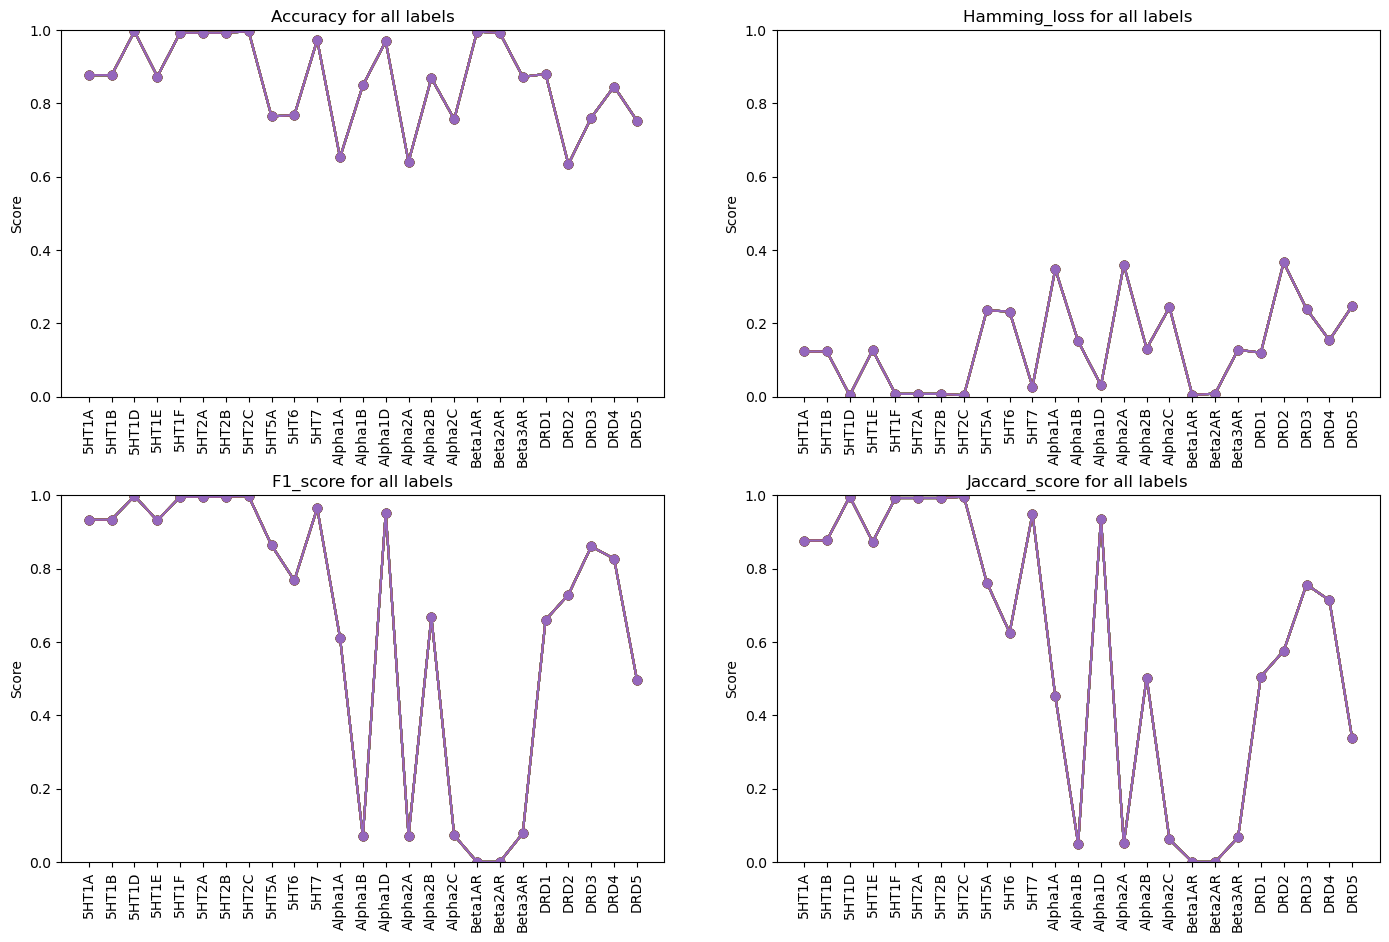

In [ ]:
# Calculate mean and standard deviation for overall metrics
metrics_cv = {key: [score[key] for score in cv_scores] for key in cv_scores[0]}
for metric, values in metrics_cv.items():
    print(
        f"{metric.capitalize()}: Mean = {np.mean(values):.2f}, Std = {np.std(values):.2f}"
    )

# Calculate mean and standard deviation for each label's metrics
for label, scores in cv_label_scores.items():
    print(f"\nMetrics for label: {label}")
    label_metrics = {key: [score[key] for score in scores] for key in scores[0]}
    for metric, values in label_metrics.items():
        print(
            f"{metric.capitalize()}: Mean = {np.mean(values):.2f}, Std = {np.std(values):.2f}"
        )


# Calculate mean and standard deviation for each label's metrics
cv_label_metrics_summary = {}
for label, scores in cv_label_scores.items():
    label_metrics = {key: [score[key] for score in scores] for key in scores[0]}
    cv_label_metrics_summary[label] = {
        metric: (np.mean(values), np.std(values))
        for metric, values in label_metrics.items()
    }

# Plotting the metrics for each label
metrics_to_plot = ["accuracy", "hamming_loss", "f1_score", "jaccard_score"]
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()
fig.tight_layout(pad=5.0)


for i, metric in enumerate(metrics_to_plot):
    ax = axes[i]
    ax.set_title(f"{metric.capitalize()} for all labels")
    for label in y.columns:
        means = [cv_label_metrics_summary[label][metric][0] for label in y.columns]
        stds = [cv_label_metrics_summary[label][metric][1] for label in y.columns]
        ax.plot(y.columns, means, marker="o", label=label)
    ax.set_ylabel("Score")
    ax.set_ylim(0, 1)
    # ax.legend()
    ax.set_xticks(range(len(y.columns)))
    ax.set_xticklabels(y.columns, rotation=90)

plt.show()

for i, metric in enumerate(metrics_to_plot):
    ax = axes[i]
    ax.set_title(f"{metric.capitalize()} for all labels")
    means = [cv_label_metrics_summary[label][metric][0] for label in y.columns]
    stds = [cv_label_metrics_summary[label][metric][1] for label in y.columns]

    ax.plot(range(len(y.columns)), means, marker="o")
    ax.fill_between(
        range(len(y.columns)),
        np.array(means) - np.array(stds),
        np.array(means) + np.array(stds),
        alpha=0.2,
    )

    ax.set_ylabel("Score")
    ax.set_ylim(0, 1)
    ax.set_xticks(range(len(y.columns)))
    ax.set_xticklabels(y.columns, rotation=90)

plt.show()


## Nested CV + Simple CV

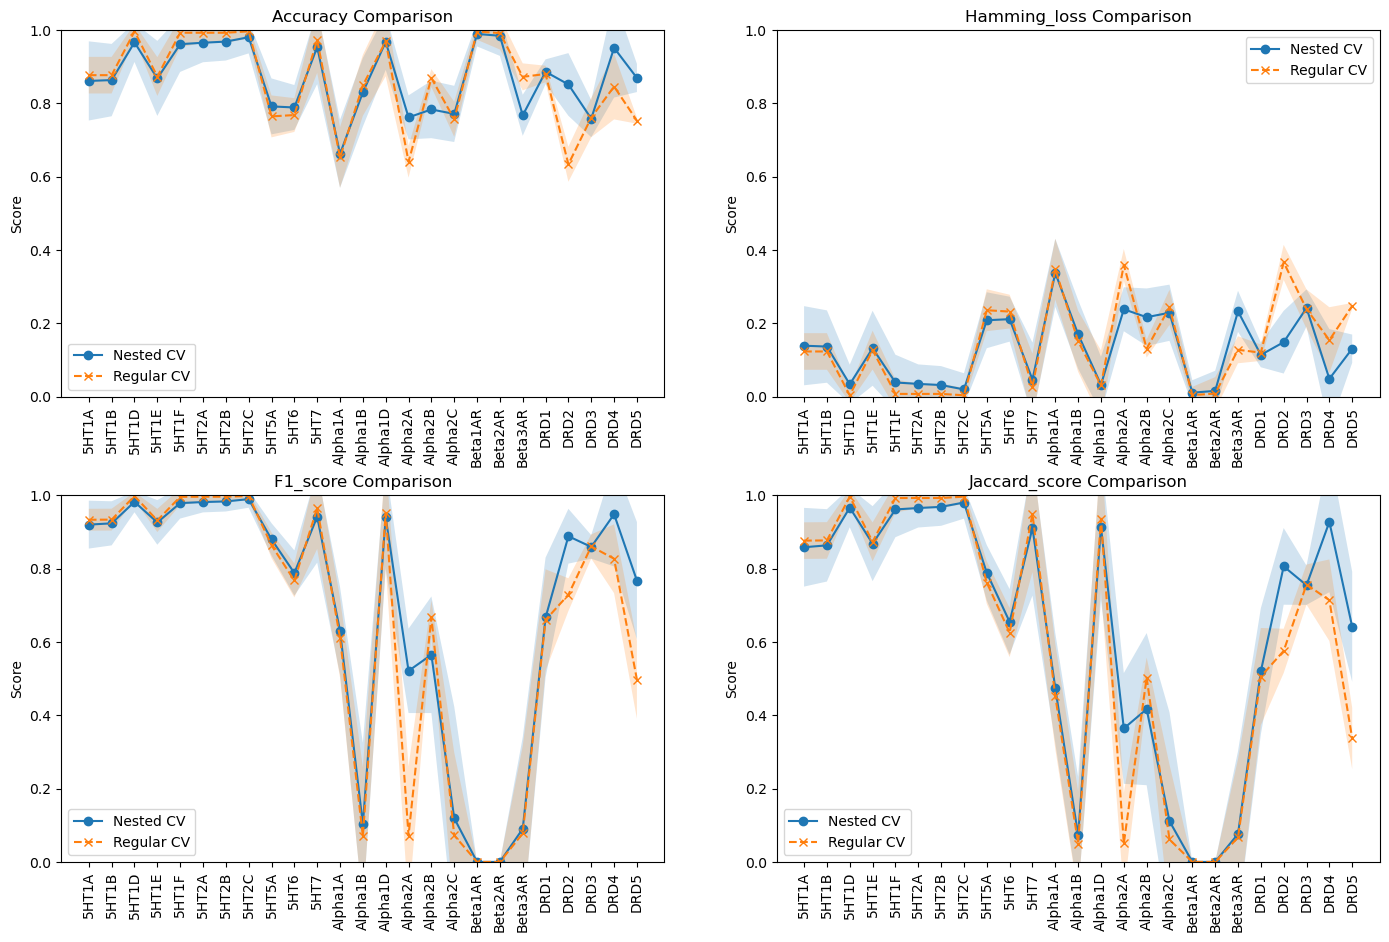

In [19]:
# Combine Nested CV and Regular CV metrics in a single plot
metrics_to_plot = ["accuracy", "hamming_loss", "f1_score", "jaccard_score"]
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()
fig.tight_layout(pad=5.0)

for i, metric in enumerate(metrics_to_plot):
    ax = axes[i]
    ax.set_title(f"{metric.capitalize()} Comparison")

    # Nested CV
    nested_means = [ncv_label_metrics_summary[label][metric][0] for label in y.columns]
    nested_stds = [ncv_label_metrics_summary[label][metric][1] for label in y.columns]
    ax.plot(range(len(y.columns)), nested_means, marker="o", label="Nested CV")
    ax.fill_between(
        range(len(y.columns)),
        np.array(nested_means) - np.array(nested_stds),
        np.array(nested_means) + np.array(nested_stds),
        alpha=0.2,
    )

    # Regular CV
    cv_means = [cv_label_metrics_summary[label][metric][0] for label in y.columns]
    cv_stds = [cv_label_metrics_summary[label][metric][1] for label in y.columns]
    ax.plot(
        range(len(y.columns)), cv_means, marker="x", linestyle="--", label="Regular CV"
    )
    ax.fill_between(
        range(len(y.columns)),
        np.array(cv_means) - np.array(cv_stds),
        np.array(cv_means) + np.array(cv_stds),
        alpha=0.2,
    )

    ax.set_ylabel("Score")
    ax.set_ylim(0, 1)
    ax.set_xticks(range(len(y.columns)))
    ax.set_xticklabels(y.columns, rotation=90)
    ax.legend()

plt.show()
